# fastMRI
Python 3.6+, Tensorflow 2.0.0-dev20190601

In [1]:
ll -h /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5

-rw-rw-r-- 1 ubuntu 91M May 31 18:39 /home/ubuntu/cs230/data/fastmri/raw/file1000000.h5


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, glob
import h5py # for loading .h5 files
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
plt.style.use('seaborn') # pretty matplotlib plots
plt.rcParams["axes.grid"] = False # don't show grid lines on plots by default
plt.rcParams['figure.figsize'] = (12, 16) # increase size of subplots

In [5]:
import cs230_project_utilities as utils

# Convert raw data into TFRecord dataset

In [6]:
# Location of .h5 files
raw_data_directory = '/home/ubuntu/cs230/data/fastmri/raw'

In [7]:
ls $raw_data_directory

file1000000.h5  file1000002.h5  file1000004.h5
file1000001.h5  file1000003.h5  file1000005.h5


In [8]:
# Convert raw data to TFRecord dataset
tfrecord_directory = 'fastmri-test-tfrecords'
utils.fastmri.convert_fastmri_dataset_to_tfrecord_files(raw_data_directory, tfrecord_directory)

In [9]:
ll -h $tfrecord_directory

total 460M
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-0.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-10.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-11.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-12.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-13.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-14.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-15.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-16.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-17.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-18.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-19.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-1.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-20.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-21.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-22.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-23.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 shard-24.tfrecord
-rw-rw-r-- 1 ubuntu  18M Jun  3 02:39 s

# Visualize the effects of various preprocessing techniques

In [10]:
data_locations = os.path.join(tfrecord_directory, '*.tfrecord')

## No preprocessing

In [11]:
# Load data

dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=4,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=None)

# Get first batch

batch = next(iter(dataset))

x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri.combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape

Loading dataset... Shuffle items? True. Shuffle buffer: 4


((640, 368), (320, 320))

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


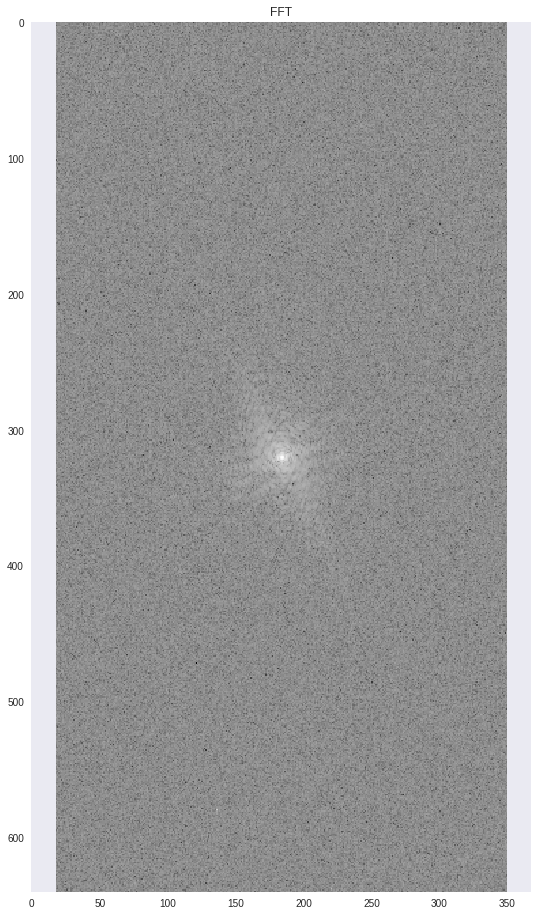

In [12]:
plt.title('FFT')
utils.plot.imshowfft(x)

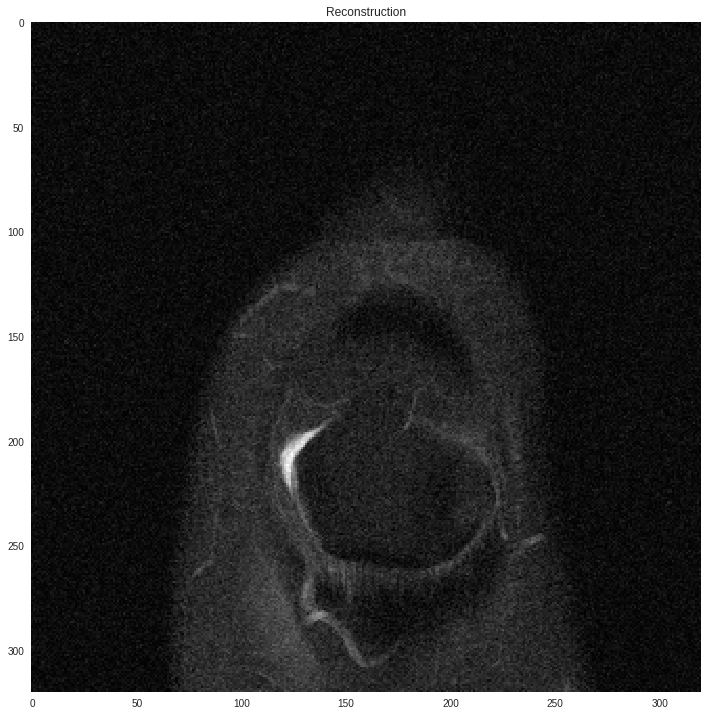

In [13]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)

## Preprocessing: 1) reshape FFT and reconstructions to (256, 256)

In [14]:
# Create preprocessing functions

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=(256, 256),
                                  use_tiled_reflections=False,
                                  subsampling_mask_function=None)

# Load data

dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=4,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

# Get first batch

batch = next(iter(dataset))

x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri.combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape, np.allclose(y, np.abs(utils.signal_processing.tf_ifft2d(x))) # Verify shapes and computations

Loading dataset... Shuffle items? True. Shuffle buffer: 4


((256, 256), (256, 256), True)

## Preprocessing: 1) use mask to subsample FFTs

In [15]:
# Create preprocessing functions

# Center fraction: how much of center columns to keep
# Acceleration: by how much to accelerate sensor data collection (e.g., if acceleration == 4, then we go 4x as fast)
subsampling_mask_fn = utils.fastmri.SubsamplingMaskCreator(center_fractions=[0.08, 0.04],
                                                           accelerations=[4, 8])

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=None,
                                  use_tiled_reflections=False,
                                  subsampling_mask_function=subsampling_mask_fn)

# Load data

dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=4,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

# Get first batch

batch = next(iter(dataset))

x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri.combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape, np.allclose(y, np.abs(utils.signal_processing.tf_ifft2d(x))) # Verify shapes and computations

Loading dataset... Shuffle items? True. Shuffle buffer: 4


((640, 368), (640, 368), True)

/home/ubuntu/cs230/code/MRI_reconstruction_example/cs230_project_utilities/plot.py:13: RuntimeWarning: divide by zero encountered in log10
  imshowgray(20 * np.log10(np.abs(fft)))


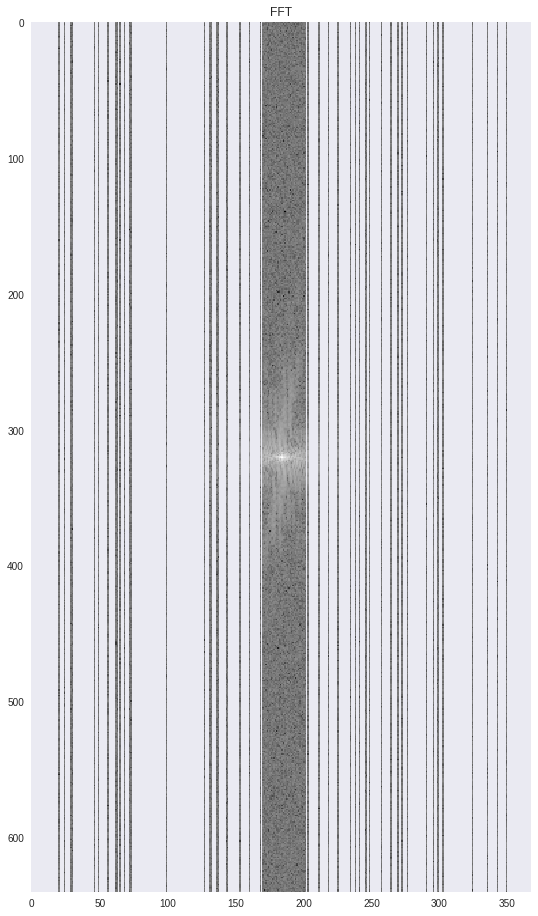

In [16]:
plt.title('FFT')
utils.plot.imshowfft(x)

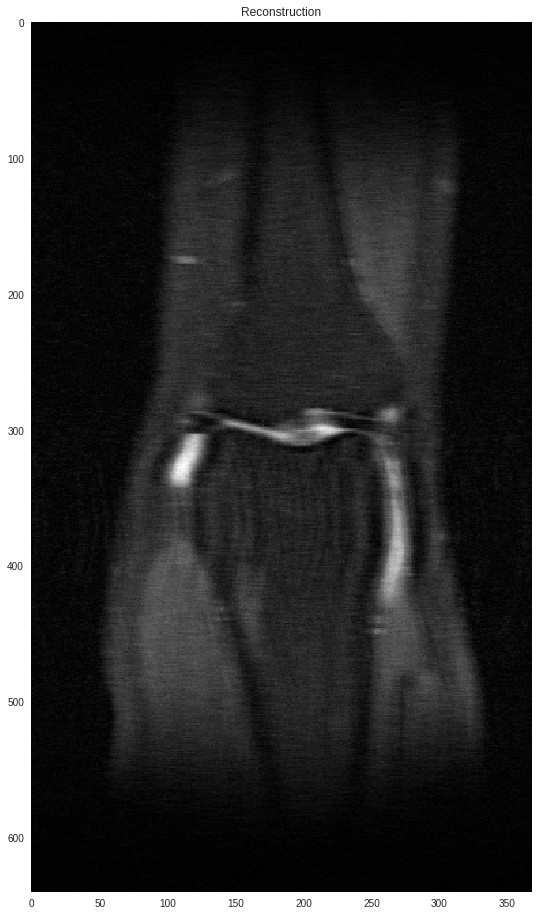

In [17]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)

## Preprocessing: 1) subsample, 2) reshape, and 3) tile and randomly crop reflections (as data augmentation)

In [18]:
# Create preprocessing functions

subsampling_mask_fn = utils.fastmri.SubsamplingMaskCreator(center_fractions=[0.08, 0.04], accelerations=[4, 8])

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=(256, 256),
                                  use_tiled_reflections=True,
                                  subsampling_mask_function=subsampling_mask_fn)

# Load data

dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=4,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

# Get first batch

batch = next(iter(dataset))

x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri.combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape, np.allclose(y, np.abs(utils.signal_processing.tf_ifft2d(x))) # Verify shapes and computations

Loading dataset... Shuffle items? True. Shuffle buffer: 4


((256, 256), (256, 256), True)

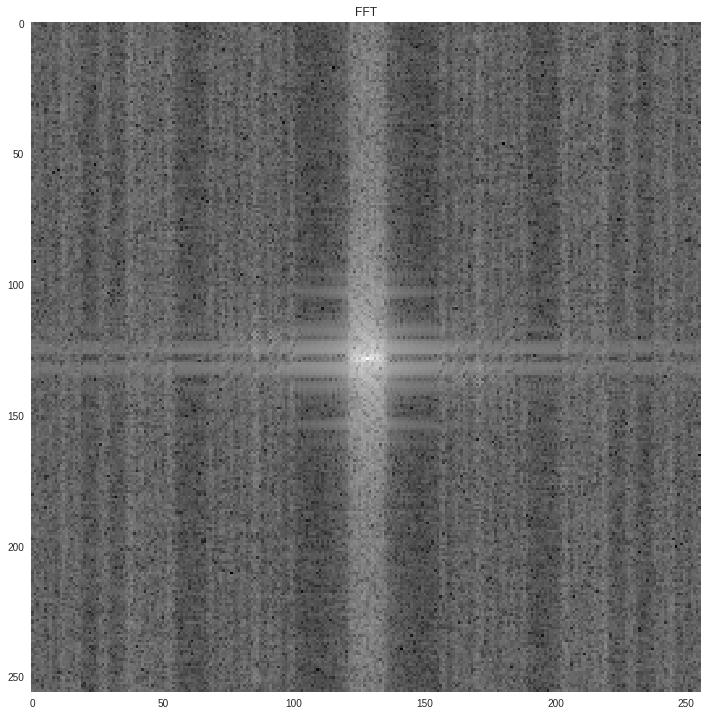

In [19]:
plt.title('FFT')
utils.plot.imshowfft(x)

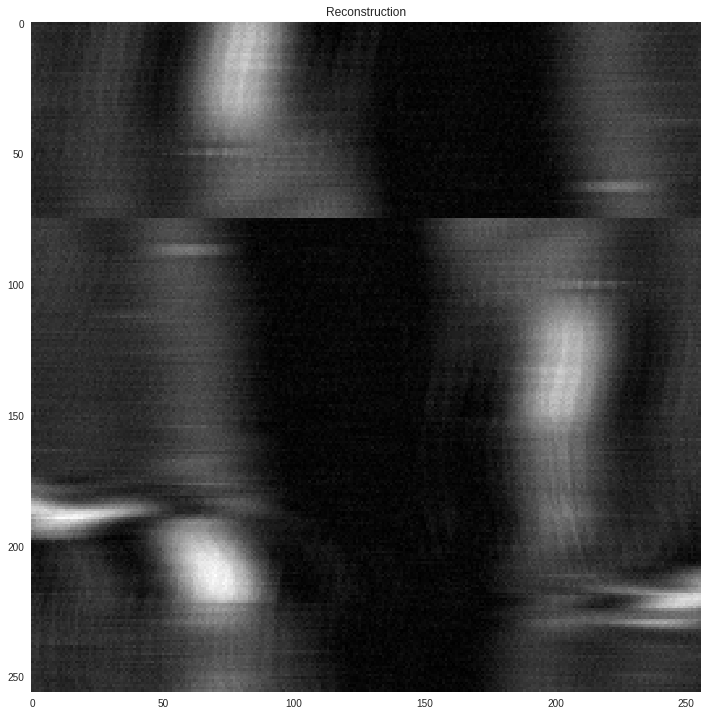

In [20]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)

## Preprocessing: 1) tile and randomly crop reflections, and 2) reshape

In [21]:
# Create preprocessing functions

subsampling_mask_fn = utils.fastmri.SubsamplingMaskCreator(center_fractions=[0.08, 0.04], accelerations=[4, 8])

preprocessing_fn = utils.fastmri.fastMRIPreprocessor(shape=(256, 256),
                                  use_tiled_reflections=True,
                                  subsampling_mask_function=None)

# Load data

dataset = utils.fastmri.load_dataset(data_locations,
                                     batch_size=8,
                                     shuffle_buffer_size=4,
                                     include_all_parsed_features=False,
                                     ignore_errors=True,
                                     preprocessing_function=preprocessing_fn)

# Get first batch

batch = next(iter(dataset))

x, y = batch
x, y = x[0].numpy().squeeze(), y[0].numpy().squeeze()


# For visualization, combine 2 channels of complex tensor into single channel
x = utils.fastmri.combine_two_channels_of_complex_tensor(x).numpy()

x.shape, y.shape, np.allclose(y, np.abs(utils.signal_processing.tf_ifft2d(x))) # Verify shapes and computations

Loading dataset... Shuffle items? True. Shuffle buffer: 4


((256, 256), (256, 256), True)

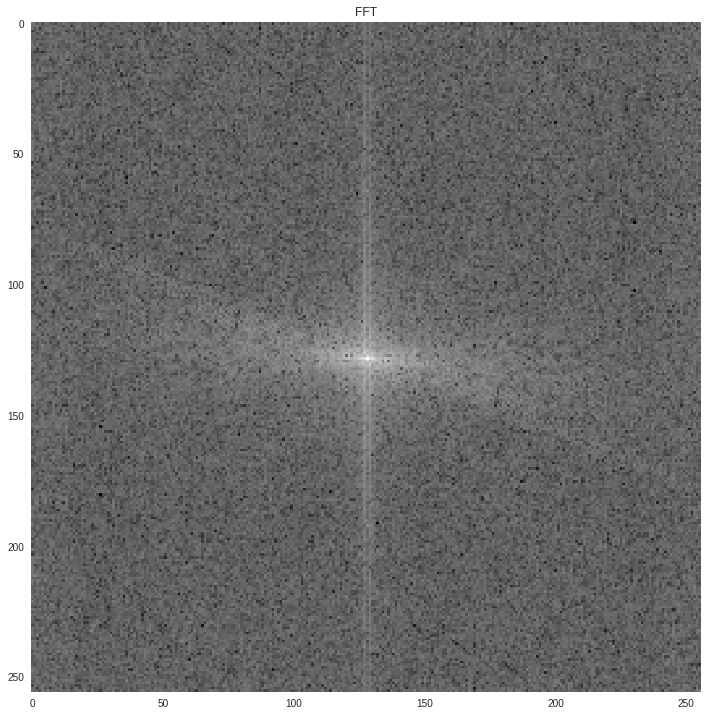

In [22]:
plt.title('FFT')
utils.plot.imshowfft(x)

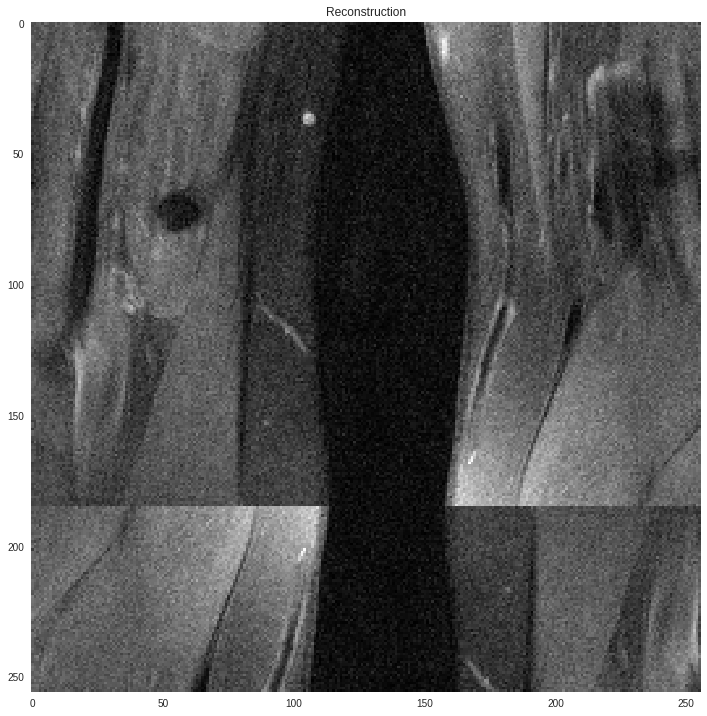

In [23]:
plt.title('Reconstruction')
utils.plot.imshowgray(y)